In [29]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing, impute, model_selection, decomposition

### Import EPA Pollution and Census American Community Survey Data

In [72]:
epa = pd.read_csv('../dataset/epa_pollution.csv')
census = pd.read_csv('../dataset/census_acs.csv')

#only use data with common cbsa codes
common_cbsa = set(epa['cbsa_code'].unique())
common_cbsa.intersection_update(census['cbsa_code'].unique())

# Standardized cbsa code datasets
pollution = epa[epa['cbsa_code'].isin(common_cbsa)]
soc_econ = census[census['cbsa_code'].isin(common_cbsa)]

In [73]:
len(common_cbsa)

339

## Data Preprocessing

### Census ACS 

In [74]:
# Remove redundant/irrelevant columns
soc_econ = soc_econ.drop(['metropolitan_area', 'city', 'state'], axis=1)

# Normalize columns
# Income
income = [i for i in soc_econ.columns if '$' in i]
for col in income:
    soc_econ[col] = soc_econ[col]/soc_econ['Income_Total']
soc_econ.drop('Income_Total', axis=1, inplace=True)

#Education
education = [i for i in soc_econ.columns if ('degree' in i) or ('graduate' in i)]
for col in education:
    soc_econ[col] = soc_econ[col]/soc_econ['Education_Total']
soc_econ.drop('Education_Total', axis=1, inplace=True)

# Occupation
occupation = [i for i in soc_econ.columns if (i not in income) and (i not in education) and (i not in ['cbsa_code', 'year', 'Occupation_Total'])]
for col in occupation:
    soc_econ[col] = soc_econ[col]/soc_econ['Occupation_Total']
soc_econ.drop('Occupation_Total', axis=1, inplace=True)

soc_econ.sort_values(['year', 'cbsa_code'], axis=0, inplace=True)
soc_econ.head()

,cbsa_code,Less than high school graduate,High school graduate (includes equivalency),Some college or associate's degree,Bachelor's degree,Graduate or professional degree,"$45,000 to $49,999","$50,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999",...,"Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services","Other services, except public administration",Public administration,"Management, business, science, and arts occupations",Service occupations,Sales and office occupations,"Natural resources, construction, and maintenance occupations","Production, transportation, and material moving occupations",year
1,10420,0.109590,0.342669,0.266596,0.183831,0.097314,0.043547,0.085722,0.105218,0.116918,...,0.224313,0.087933,0.047411,0.029834,0.341412,0.164147,0.268786,0.001810,0.223845,2005
2,10500,0.214530,0.323630,0.276552,0.115232,0.070055,0.046814,0.099690,0.111882,0.087279,...,0.221430,0.066773,0.066212,0.076664,0.300161,0.138019,0.246350,0.009773,0.305697,2005
3,10580,0.097922,0.308826,0.284550,0.169404,0.139298,0.046200,0.092376,0.111600,0.137878,...,0.259730,0.069128,0.038137,0.110608,0.397041,0.151805,0.270669,0.002259,0.178227,2005
4,10740,0.140155,0.265774,0.293919,0.169377,0.130775,0.043810,0.083659,0.113831,0.102810,...,0.223604,0.094226,0.045499,0.063296,0.374627,0.166710,0.264363,0.002006,0.192294,2005
5,10780,0.176673,0.371108,0.262197,0.136293,0.053729,0.041082,0.072454,0.070793,0.091749,...,0.302493,0.063796,0.038255,0.085138,0.334400,0.170620,0.256644,0.007136,0.231201,2005


In [75]:
soc_econ.shape

(4644, 33)

#### PCA

Since there are 33 attributes and only 5K instances, it may not be sufficient for a successful clustering analysis.

In [84]:
#Capture 90% variance 
pca = decomposition.PCA(n_components=.90, svd_solver='full')

#only apply PCA on the continious variables 
continuous = soc_econ.drop(['cbsa_code', 'year'], axis=1)
reduced_census = pd.DataFrame(pca.fit_transform(continuous))
reduced_census['cbsa_code'] = soc_econ['cbsa_code']
reduced_census['year'] = soc_econ['year']

soc_econ = red_census
soc_econ.shape

(4644, 11)

### EPA Pollution

Clean up data, to remove scarse data points (cities that don't have enough measurements per year or pollutants)

In [28]:
pollution = pollution.sort_values(['year', 'cbsa_code', 'parameter', 'sample_duration', 'datum', 'metric_used'], axis=0) # Sort by timeseries, cbsa..
pollution = pollution[pollution['observation_count'] > 365]                                                              # remove instances without sufficent year observations 

#Remove clearly unecessary and redundant columns
skip = ['latitude', 'longitude', 'metric_used', 'state', 'county', 'city']
skip.extend([i for i in pollution.columns if 'datetime' in i])
pollution = pollution.drop(columns=skip)
pollution[pollution['parameter'].str.contains('PM2.5')].to_csv('../dataset/epa_pollution_clean.csv', index=False)        

# pollution.groupby(['parameter', 'sample_duration', 'metric_used']).size().reset_index().rename(columns={0:'count'})

###  Dynamic Time Warping K-Means Clustering

In [59]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=50, random_state=143)
y_pred = model.fit_predict(soc_econ)

In [60]:
model.cluster_centers_.shape

(3, 33, 1)

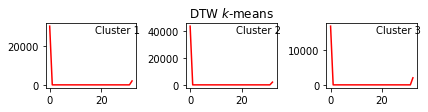

In [74]:
for yi in range(3):
    plt.subplot(3, 3, 7 + yi)    
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.tight_layout() 
plt.show()